# TV Momentum Match Lab\n\nVisualize strict Pine-style `MomLE`/`MomSE` stop-order fills from `momentum_strategy_tv_match.py`.\n

Loaded 777 rows from /home/unionhills/Projects/GitHub/trading-signals/out/indicators/momentum_tv_match/weekly/APO.csv
Plot window: 2021-02-28 -> 2026-02-22
Event fills in window: 15


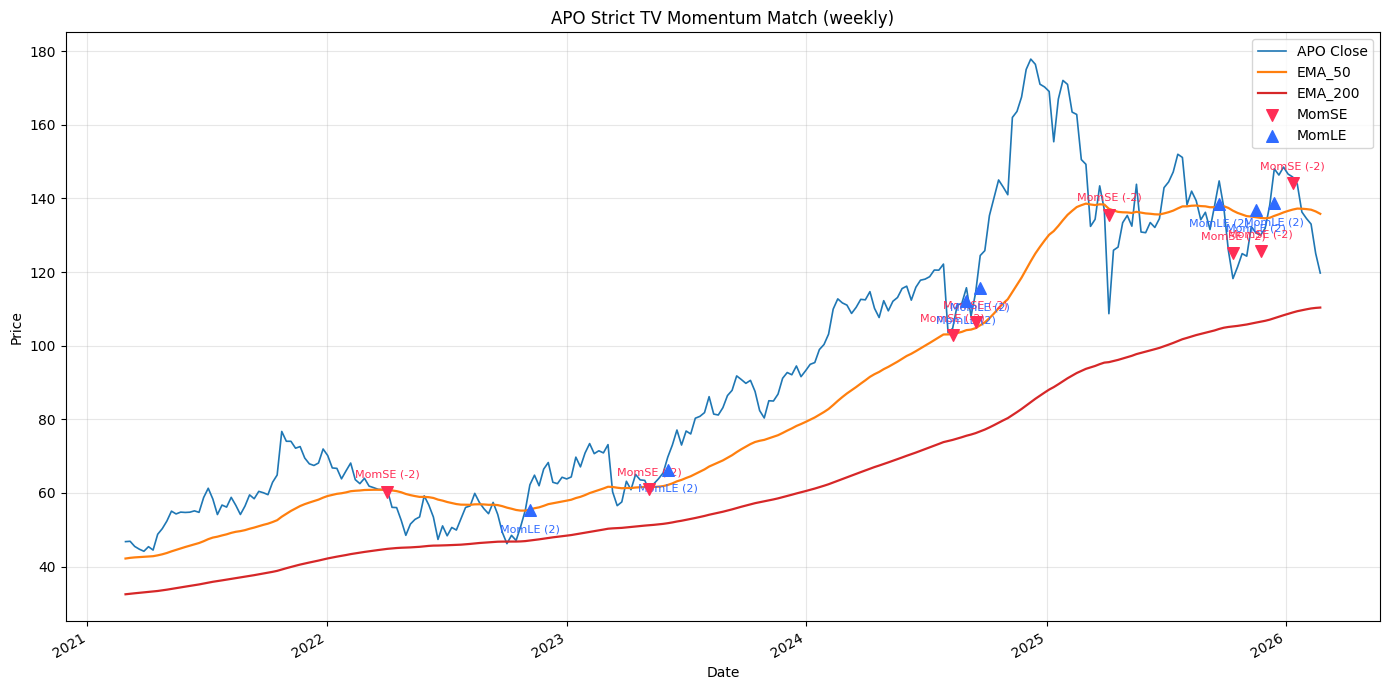

Latest 12 bars:
2025-12-07  event= action= delta=0 pos=SHORT long_cond=1 short_cond=0
2025-12-14  event=MomLE action=REVERSE_TO_LONG delta=2 pos=LONG long_cond=1 short_cond=0
2025-12-21  event= action= delta=0 pos=LONG long_cond=0 short_cond=0
2025-12-28  event= action= delta=0 pos=LONG long_cond=0 short_cond=0
2026-01-04  event= action= delta=0 pos=LONG long_cond=0 short_cond=1
2026-01-11  event=MomSE action=REVERSE_TO_SHORT delta=-2 pos=SHORT long_cond=0 short_cond=0
2026-01-18  event= action= delta=0 pos=SHORT long_cond=1 short_cond=0
2026-01-25  event= action= delta=0 pos=SHORT long_cond=0 short_cond=1
2026-02-01  event= action= delta=0 pos=SHORT long_cond=0 short_cond=0
2026-02-08  event= action= delta=0 pos=SHORT long_cond=0 short_cond=0
2026-02-15  event= action= delta=0 pos=SHORT long_cond=0 short_cond=1
2026-02-22  event= action= delta=0 pos=SHORT long_cond=0 short_cond=1


In [1]:
from pathlib import Path
import csv
from datetime import date, timedelta
import matplotlib.pyplot as plt

SYMBOL = "APO"
TIMEFRAME = "weekly"  # daily | weekly | monthly
YEARS_TO_PLOT = 5


def resolve_repo_root() -> Path:
    candidates = [Path.cwd(), Path.cwd().parent]
    for candidate in candidates:
        if (candidate / "out").exists():
            return candidate
    raise FileNotFoundError("Could not find repo root with out/")


def parse_float(value: str | None) -> float | None:
    raw = (value or "").strip()
    if not raw:
        return None
    return float(raw)


def compute_ema(values: list[float], period: int) -> list[float | None]:
    out: list[float | None] = [None] * len(values)
    if period <= 0 or len(values) < period:
        return out
    alpha = 2.0 / (period + 1.0)
    seed = sum(values[:period]) / period
    out[period - 1] = seed
    prev = seed
    for idx in range(period, len(values)):
        curr = (values[idx] - prev) * alpha + prev
        out[idx] = curr
        prev = curr
    return out


repo = resolve_repo_root()
match_csv = repo / "out" / f"momentum_tv_match_{TIMEFRAME}" / f"{SYMBOL}.csv"
if not match_csv.exists():
    raise FileNotFoundError(
        f"Missing strict match output: {match_csv}. "
        f"Run: python3 -m scripts.indicators.momentum_strategy_tv_match --symbols {SYMBOL} --timeframe {TIMEFRAME} --length 24 --min-tick 0.01"
    )

rows = list(csv.DictReader(match_csv.open("r", encoding="utf-8", newline="")))
rows.sort(key=lambda r: r["Date"])
if not rows:
    raise ValueError("No rows in strict match output")

dates = [date.fromisoformat(r["Date"]) for r in rows]
closes = [float(r["Close"]) for r in rows]
ema50 = compute_ema(closes, 50)
ema200 = compute_ema(closes, 200)

fill_events = []
for idx, r in enumerate(rows):
    event = (r.get("Event") or "").strip()
    if not event:
        continue
    fill_price = parse_float(r.get("FillPrice"))
    y = closes[idx] if fill_price is None else fill_price
    fill_events.append((idx, event, y, (r.get("Action") or "").strip(), (r.get("TradeDelta") or "").strip()))

start_date = dates[-1] - timedelta(days=365 * YEARS_TO_PLOT)
start_idx = next((i for i, d in enumerate(dates) if d >= start_date), 0)

plot_dates = dates[start_idx:]
plot_close = closes[start_idx:]
plot_ema50 = ema50[start_idx:]
plot_ema200 = ema200[start_idx:]
plot_events = [e for e in fill_events if e[0] >= start_idx]

print(f"Loaded {len(rows)} rows from {match_csv}")
print(f"Plot window: {plot_dates[0]} -> {plot_dates[-1]}")
print(f"Event fills in window: {len(plot_events)}")

fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.plot(plot_dates, plot_close, color="#1f77b4", linewidth=1.2, label=f"{SYMBOL} Close")
ax.plot(plot_dates, plot_ema50, color="#ff7f0e", linewidth=1.6, label="EMA_50")
ax.plot(plot_dates, plot_ema200, color="#d62728", linewidth=1.6, label="EMA_200")

seen = set()
for idx, event, y, action, delta in plot_events:
    row_date = dates[idx]
    if event == "MomLE":
        color, marker, name, offset = "#2f6bff", "^", "MomLE", -16
    else:
        color, marker, name, offset = "#ff2d55", "v", "MomSE", 10

    label = name if name not in seen else "_nolegend_"
    seen.add(name)
    ax.scatter([row_date], [y], color=color, marker=marker, s=70, zorder=8, label=label)
    note = f"{name} ({delta})" if delta else name
    ax.annotate(note, (row_date, y), textcoords="offset points", xytext=(0, offset), ha="center", fontsize=8, color=color)

ax.set_title(f"{SYMBOL} Strict TV Momentum Match ({TIMEFRAME})")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.grid(alpha=0.3)
ax.legend(loc="best")
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

print("Latest 12 bars:")
for r in rows[-12:]:
    print(
        f"{r['Date']}  event={r.get('Event','')} action={r.get('Action','')} "
        f"delta={r.get('TradeDelta','')} pos={r.get('Position','')} "
        f"long_cond={r.get('LongCondition','')} short_cond={r.get('ShortCondition','')}"
    )
